# Exemple série temporelle 2: monthly milk production
L'ensemble de données décrit une série chronologique de la production électrique, de 1985 à 2014

In [49]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import math
import smtplib

from datetime import datetime
from email.message import EmailMessage
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

In [50]:
df = pd.read_csv('./Electric_Production.csv')
df.head()

,DATE,IPG2211A2N
0,1/1/1985,72.5052
1,2/1/1985,70.6720
2,3/1/1985,62.4502
3,4/1/1985,57.4714
4,5/1/1985,55.3151


In [51]:
df['DATE'] = pd.to_datetime(df['DATE'])
df=df.set_index('DATE')
df.head()

,IPG2211A2N
DATE,
1985-01-01,72.5052
1985-02-01,70.6720
1985-03-01,62.4502
1985-04-01,57.4714
1985-05-01,55.3151


In [38]:
df.describe()

,IPG2211A2N
count,397.000000
mean,88.847218
std,15.387834
min,55.315100
25%,77.105200
50%,89.779500
75%,100.524400
max,129.404800


## Tracé des données

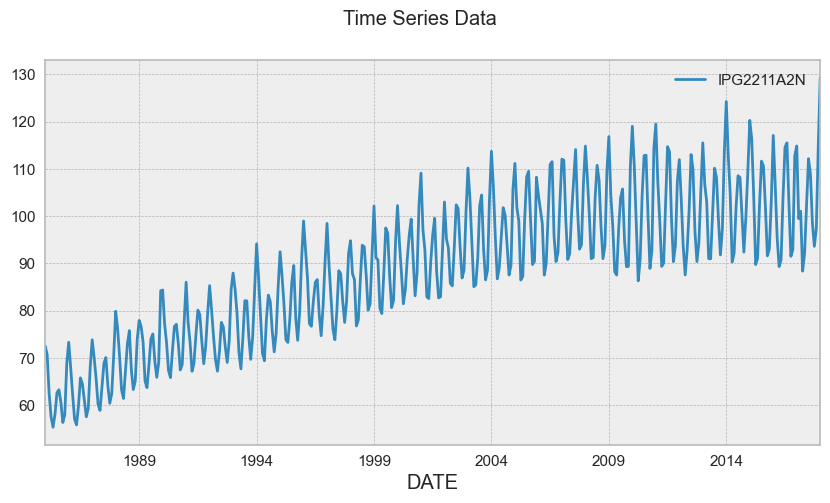

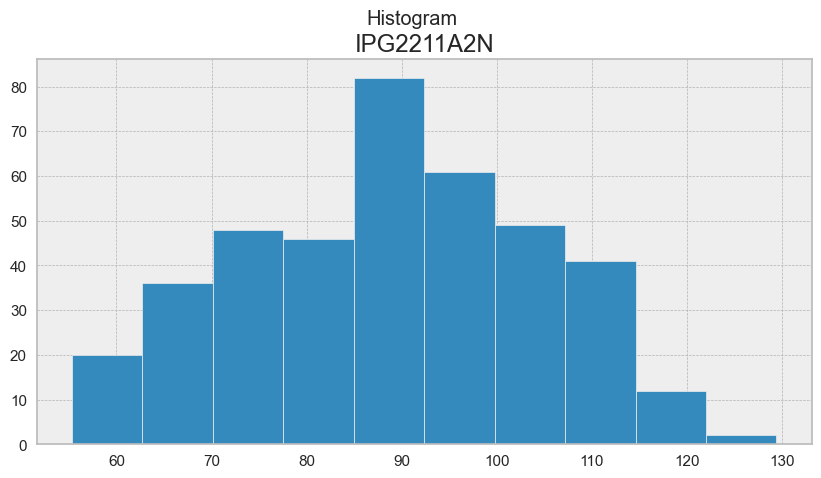

In [56]:
# Line plots of time series
fig, ax = plt.subplots(figsize=(10,5))
fig.suptitle('Time Series Data')
df.plot(ax=ax)
plt.show()
#Historgram
fig, ax = plt.subplots(figsize=(10,5))
fig.suptitle('Histogram')
df.hist(ax=ax)
plt.show()

<AxesSubplot:xlabel='DATE', ylabel='IPG2211A2N'>

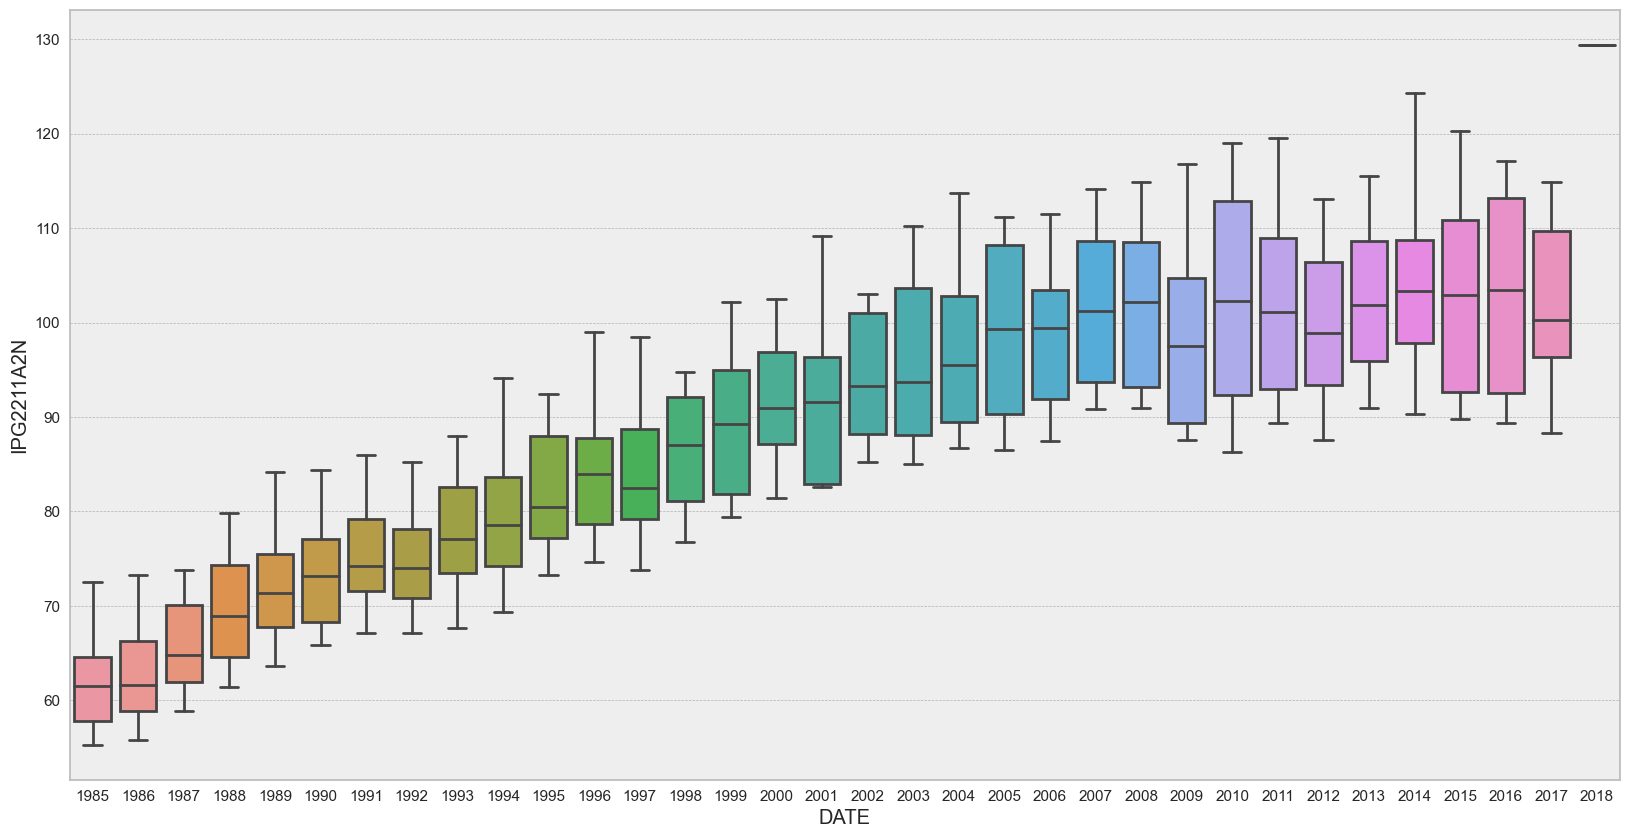

In [55]:
fig, ax = plt.subplots(figsize=(20,10))
sns.boxplot(x = df.index.year,
                y = df.IPG2211A2N, 
                ax = ax)

## décomposition de la série chronologique

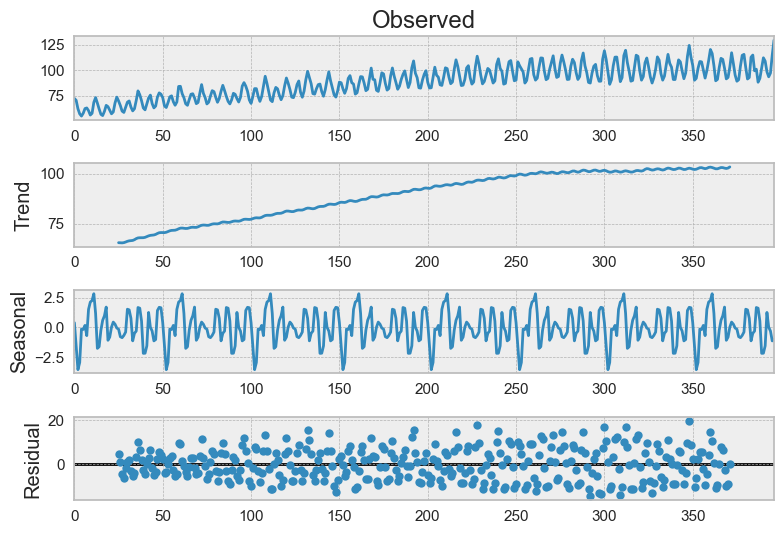

In [57]:
plt.style.use('seaborn')
series = df.IPG2211A2N.values
result = seasonal_decompose(series, model='additive', period=50)
sns.set()

plt.style.use('bmh')
result.plot()

plt.show()

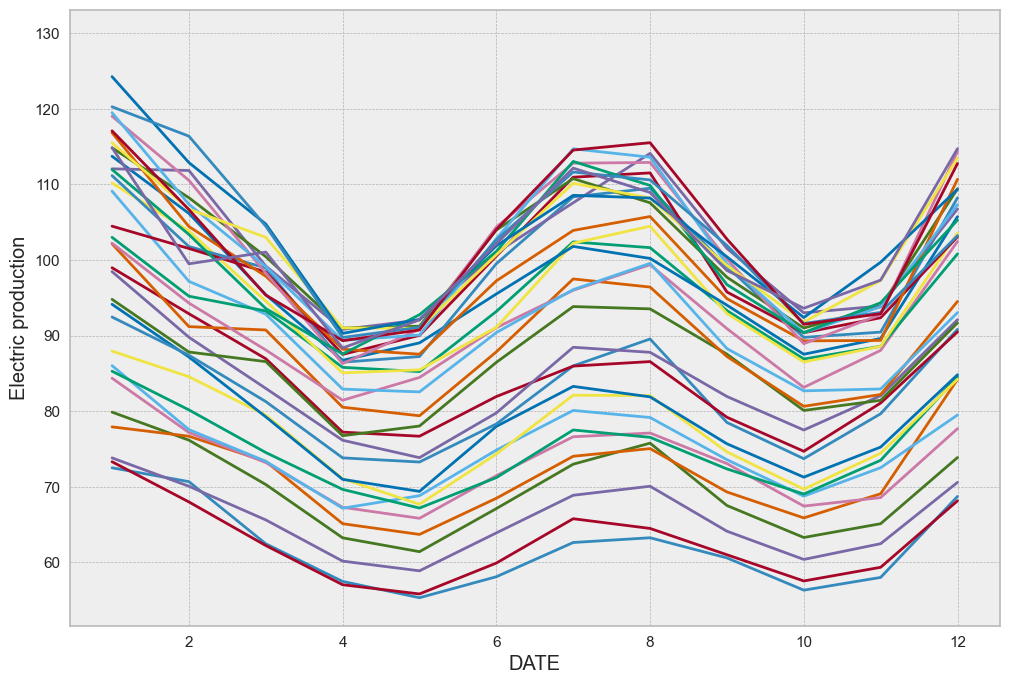

In [58]:
df['year'] = df.index.year
df['month'] = df.index.month
df_pivot = pd.pivot_table(df, values='IPG2211A2N', index='month', columns='year', aggfunc='mean')
df_pivot.plot(figsize=(12,8))
plt.legend().remove()
plt.xlabel('DATE')
plt.ylabel('Electric production')
plt.show()

C:\Anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


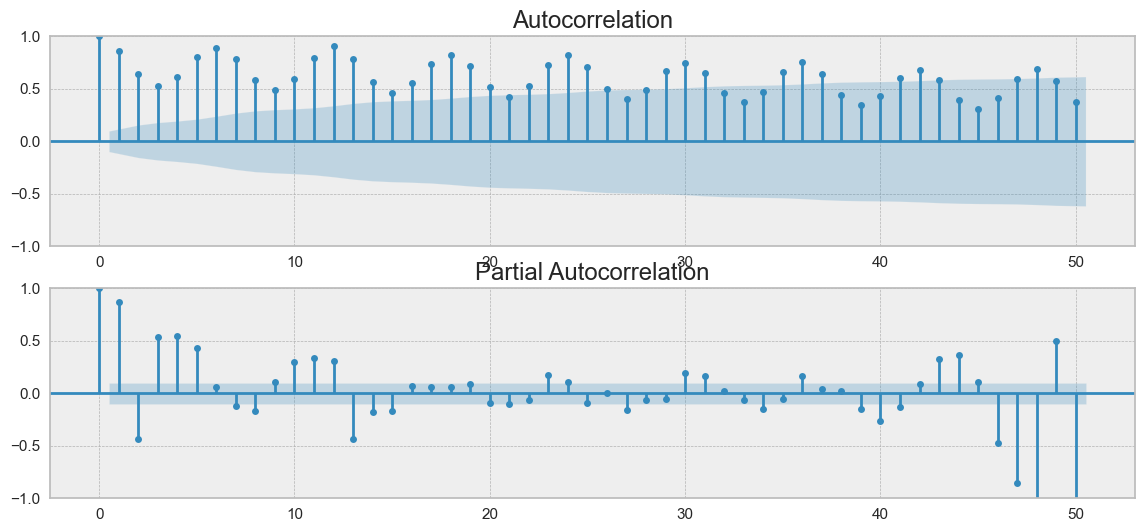

In [59]:
df.drop(['year', 'month'], axis=1, inplace=True)
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(14,6), sharex=False, sharey=False)
ax1 = plot_acf(x=df.IPG2211A2N, lags=50, ax=ax1)
ax2 = plot_pacf(df.IPG2211A2N, lags=50, ax=ax2)
plt.show()

## Test de Dickey-Fuller 
En fonction de la valeur obtenue nous décidons si il faut effectuer où non la différenciation des données . Ci-dessous, la valeur de p=0,18 , nous pouvons considérer cette série comme étant stationnaire

In [60]:
result = adfuller(df['IPG2211A2N'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Test Statistics Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -2.256990
p-value: 0.186215
Critical Test Statistics Values:
	1%: -3.448
	5%: -2.869
	10%: -2.571


## Differencier les données: transformer une série redondante en une série stationnaire

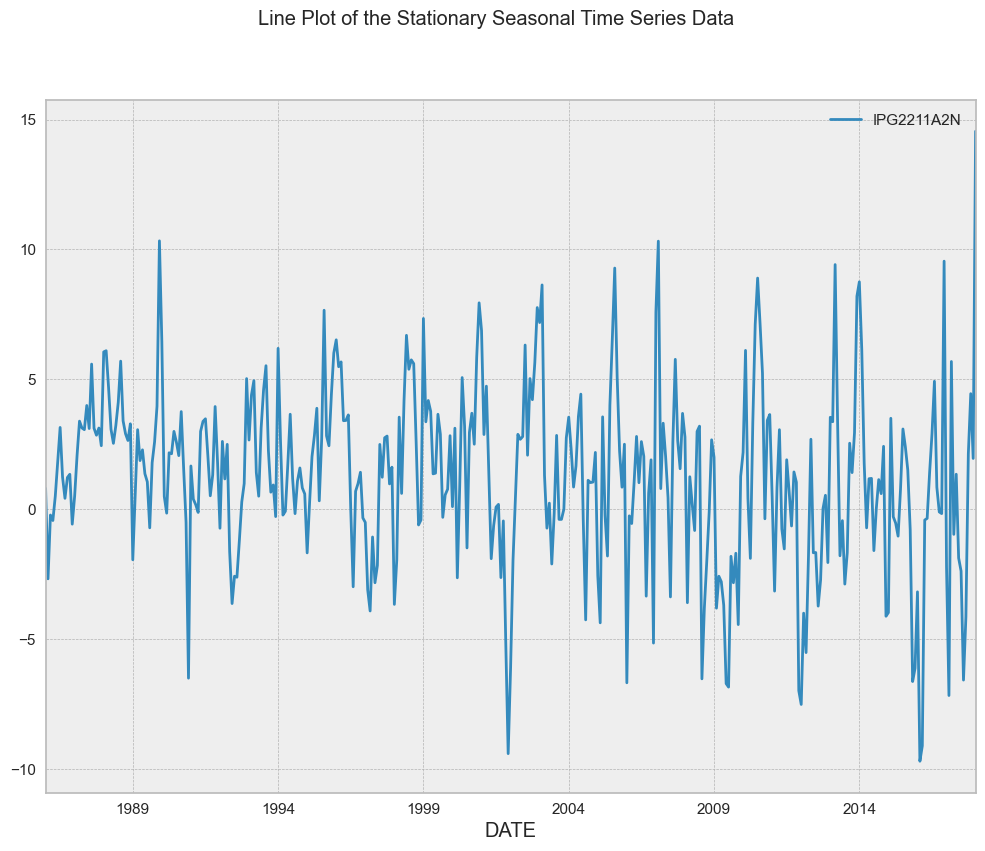

In [68]:
#time_series=time_series.set_index('Month')
df_diff = df.diff(12)
df_diff.dropna(inplace=True)

# Plot differenced data
fig, ax = plt.subplots(figsize=(12,9))
fig.suptitle('Line Plot of the Stationary Seasonal Time Series Data')
df_diff.plot(ax=ax)
plt.show()

## Estimation des meilleurs paramètres du modèle: SARIMAX

In [61]:
import pmdarima as pm
model = pm.auto_arima(df['IPG2211A2N'], d=1, D=1,seasonal=True, m=12, trend='c',start_p=0, start_q=0, max_order=6, test='adf', stepwise=True, trace=True)
print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=1865.702, Time=0.80 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=2012.117, Time=0.12 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1942.041, Time=0.66 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=1837.289, Time=0.97 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=1974.343, Time=0.27 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=1838.537, Time=1.06 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=1837.962, Time=5.75 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=1925.284, Time=0.76 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=1837.164, Time=3.67 sec
 ARIMA(0,1,1)(2,1,2)[12]             : AIC=1816.629, Time=4.67 sec
 ARIMA(0,1,1)(2,1,1)[12]             : AIC=1825.210, Time=2.79 sec
 ARIMA(0,1,0)(2,1,2)[12]             : AIC=1854.602, Time=4.11 sec
 ARIMA(1,1,1)(2,1,2)[12]             : AIC=1770.213, Time=13.91 sec
 ARIMA(1,1,1)(1,1,2)[12]             : AIC=1782.020, Time=9.55 sec
 ARIMA(1,1,1)(2,1,

<AxesSubplot:xlabel='DATE'>

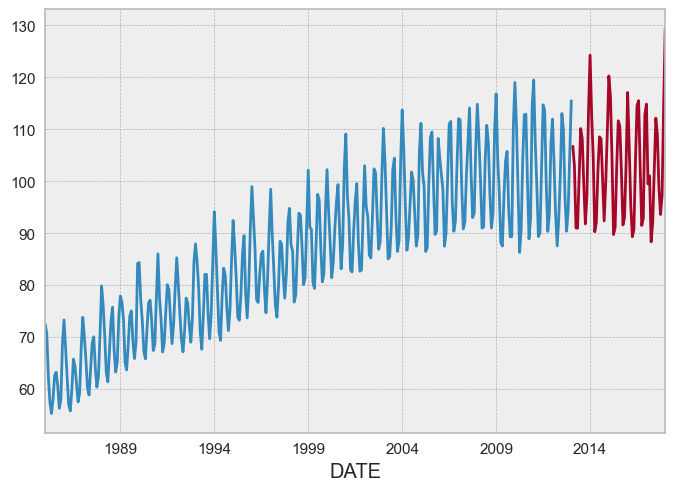

In [62]:
#divide into train and validation set
train = df[:int(0.85*(len(df)))]
test = df[int(0.85*(len(df))):]

#plotting the data
train['IPG2211A2N'].plot()
test['IPG2211A2N'].plot()

In [63]:
model = SARIMAX(train['IPG2211A2N'],order=(1,1,1),seasonal_order=(2,1,2,12))
results = model.fit()
print("Results of SARIMAX on train")
print(results.summary())

C:\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Results of SARIMAX on train
                                        SARIMAX Results                                        
Dep. Variable:                              IPG2211A2N   No. Observations:                  337
Model:             SARIMAX(1, 1, 1)x(2, 1, [1, 2], 12)   Log Likelihood                -717.382
Date:                                 Sun, 08 Jan 2023   AIC                           1448.764
Time:                                         11:36:09   BIC                           1475.229
Sample:                                     01-01-1985   HQIC                          1459.328
                                          - 01-01-2013                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4993      0.057      8.776   

## Validation

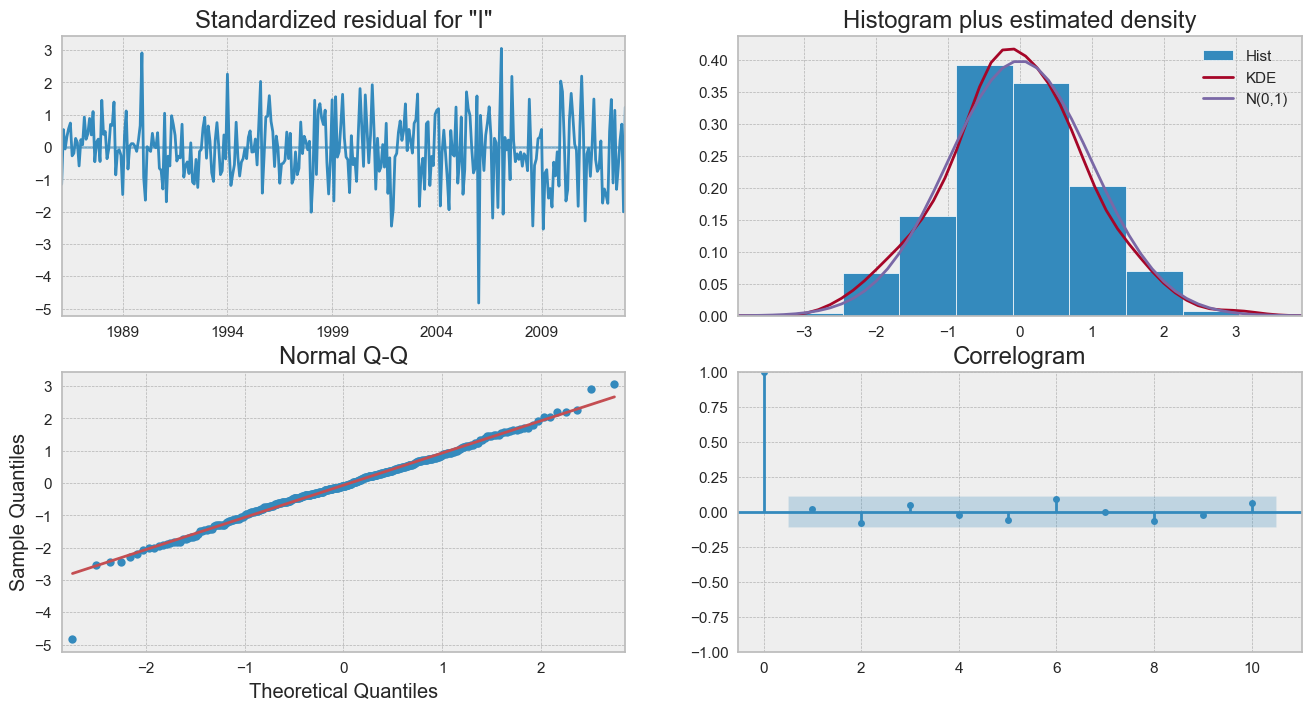

In [64]:
results.plot_diagnostics(figsize=(16, 8))
plt.savefig('modeldiagnostics')
plt.show()

## Prédiction sur les données existantes

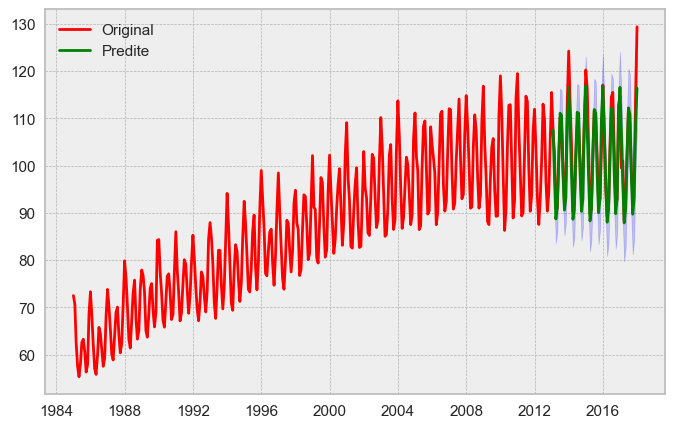

In [65]:
forecast = results.get_forecast(steps=len(test))
mean = forecast.predicted_mean
conf_int = forecast.conf_int()
d = mean.index
plt.figure(figsize=(8,5))
# Plot past  levels
plt.plot(df.index, df, label='Original', color = 'red')
# Prediction Mean
plt.plot(d, mean, label='Predite', color= 'green')
# Shade of space between  confidence intervals
plt.fill_between(d, conf_int.iloc[:,0], conf_int.iloc[:,1],
alpha=0.2, color= 'blue')
# Plot legend 
plt.legend()
plt.savefig('p')
plt.show()

In [66]:
from sklearn.metrics import r2_score
print('R2score is',r2_score(test['IPG2211A2N'], mean))
mean_absolute_percentage_error = np.mean(np.abs(mean - test['IPG2211A2N'])/np.abs(test['IPG2211A2N']))*100
print('MAPE is', mean_absolute_percentage_error)

R2score is 0.849069094120563
MAPE is 2.583328579262266


## Prédiction sur le futur

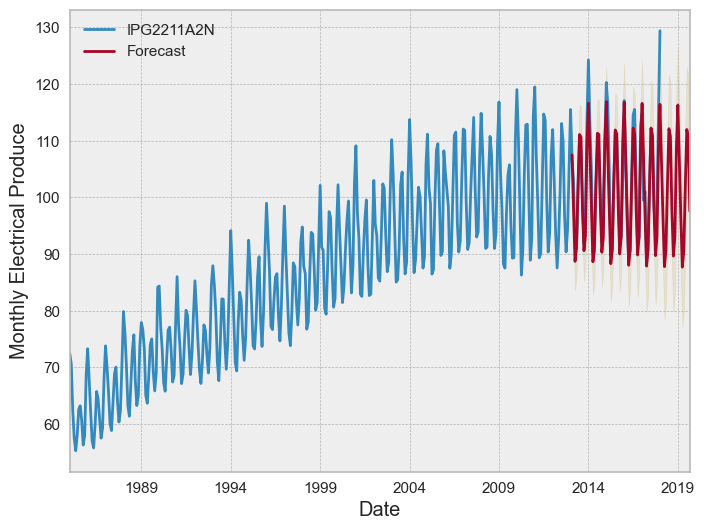

In [67]:
#Future Forecast
future = results.get_forecast(steps=80)
ci = future.conf_int()
ax = df.plot(label='Production', figsize=(8, 6))
future.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(ci.index,
                ci.iloc[:, 0],
                ci.iloc[:, 1], color='y', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Monthly Electrical Produce')
plt.legend()
plt.show()